# Práctica 3

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
import cv2

### Funciones generales:

In [2]:
def cargar(nombre):
    img = Image.open(nombre).convert(mode='L')
    return np.array(img)


def mostrar(imagen, titulo=""):
    plt.figure(figsize=(9, 9))
    if (titulo): plt.title(titulo)
    plt.imshow(imagen, cmap='gray', vmin=0, vmax=255)


def pasarALog(imagen):
    c = 255 / np.log(1 + np.max(imagen))
    resultado = np.uint8(c * np.log(1 + imagen))
    return resultado


# valor entre 0 y 255
def aplicar_umbral(imagen, valor):
    return np.uint8(np.greater(imagen, valor) * 255)


# suavizado:
def suavizado_promedio(imagen, dimension):
    H = np.ones((dimension, dimension)) / dimension ** 2
    return signal.convolve2d(imagen, H, boundary="symm", mode="same")


def eqHist(imagen):
    hist = np.histogram(imagen, 256, range=(0, 256))
    acumulado = np.cumsum(hist[0])
    normalizado = 255 * ((acumulado - acumulado.min()) / (acumulado.max() - acumulado.min()))
    resultado = np.uint8(normalizado[imagen])
    return resultado


def ventana_gauss(dimension, desviacion):
    gauss1d = signal.windows.gaussian(dimension, desviacion)
    gauss2d = np.outer(gauss1d, gauss1d)
    return gauss2d / sum(sum(gauss2d))


def suavizado_gauss(imagen, std):
    gauss = ventana_gauss(int(4 * std), std)
    return signal.convolve2d(imagen, gauss, boundary="symm", mode="same")


def bordes_gradiente(imagen, umbral, metodo="roberts"):
    #roberts:
    h1 = np.array([[-1., 0.], [0., 1.]])
    h2 = np.flip(h1, axis=1)

    if metodo == "prewitt":
        h1 = np.array([[-1., -1., -1.], [0., 0., 0.], [1., 1., 1.]])
        h2 = h1.T

    if metodo == "sobel":
        h1 = np.array([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]])
        h2 = h1.T

    im1 = signal.convolve2d(imagen, h1, boundary="symm", mode="same")
    im2 = signal.convolve2d(imagen, h2, boundary="symm", mode="same")

    imagen_res = np.abs(im1) + np.abs(im2)

    return aplicar_umbral(imagen_res, umbral)


### Detección de líneas

In [57]:

video = cv2.VideoCapture("camino1.avi")
fps = video.get(cv2.CAP_PROP_FPS)
_, frame = video.read()

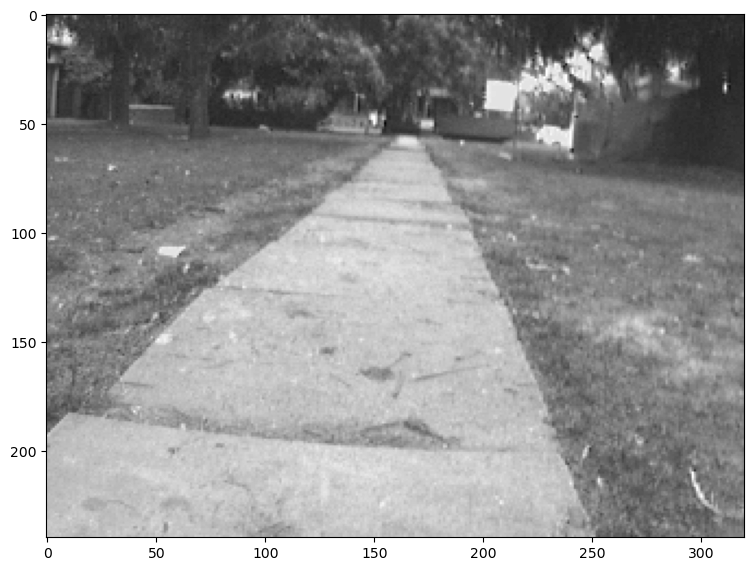

In [58]:
frame1 = frame[:, :, 0]
mostrar(frame1)

In [5]:
fps

25.0

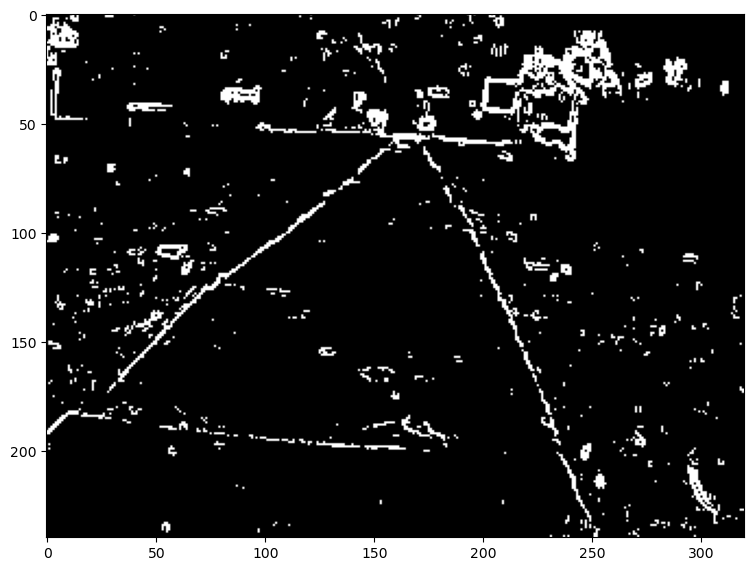

In [6]:
mostrar(bordes_gradiente(frame1, 200, "sobel"))

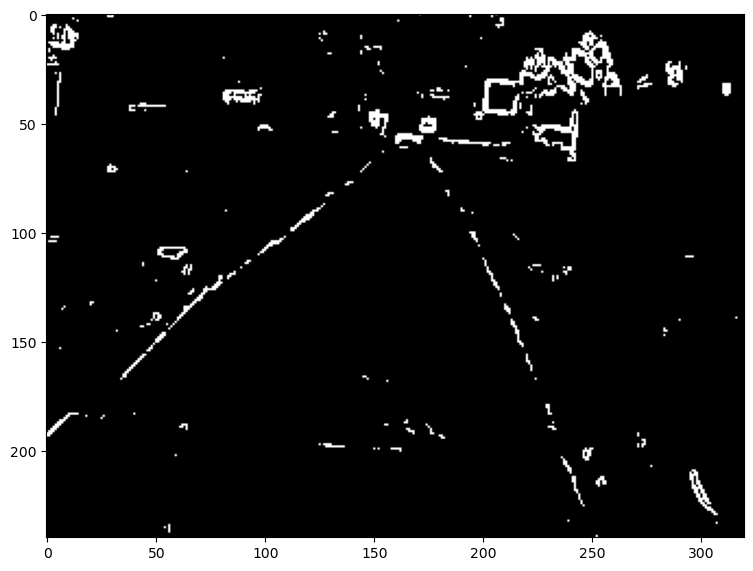

In [7]:
mostrar(bordes_gradiente(suavizado_gauss(frame1, 0.5), 240, "sobel"))

In [150]:
bordes = bordes_gradiente(suavizado_gauss(frame1, 0.5), 200, "sobel")
maximo = ((np.shape(bordes)[0] ** 2 + np.shape(bordes)[1] ** 2) ** (1 / 2)) + 1
maximo = np.int32(maximo)
donde = np.nonzero(bordes)
angulos = np.linspace(-np.pi / 2, np.pi / 2, 181)
A = np.zeros((maximo * 2, np.size(angulos)), dtype=np.int32)

it = np.nditer(angulos, flags=["c_index"])
for ang in it:
    rhos = np.int32(np.round((donde[0] + 1) * np.cos(ang) + (donde[1] + 1) * np.sin(ang))) + maximo
    cantidades = np.bincount(rhos)
    cantidades.resize(np.shape(A)[0])
    A[:, it.index] = cantidades



In [273]:
max_ocurrencia = A.max()
lineas = np.where(A > max_ocurrencia * 0.75)
tabla_lineas = np.stack((lineas[0], lineas[1])).T
columna = A[tabla_lineas[:, 0], tabla_lineas[:, 1]]
todo = np.hstack((tabla_lineas, columna.reshape(-1, 1)))
ordenado = todo[todo[:, 2].argsort()[::-1]]

#guardamos la primera recta:
resultados = ordenado[0, :2].reshape((1, 2))
umbral_angulo = 10
for i in np.arange(1, ordenado.shape[0]):
    # nos quedamos hasta 2 resultados y rectas que difieren más de 10 grados:
    if True in np.greater(np.abs(ordenado[i, 1] - resultados[:, 1]), umbral_angulo) and resultados.shape[0] < 2:
        resultados = np.vstack((resultados, ordenado[i, :2]))



In [274]:
resultados

array([[550, 130],
       [256,  22]])

In [279]:
def muestra_linea(imagen, angulo, rho):
    ancho = np.shape(imagen)[1]
    y = np.linspace(0, ancho - 1, ancho)

    x = (rho - y * np.sin(angulo)) / np.cos(angulo)

    plt.ylim(np.shape(imagen)[0], 0)

    plt.title("titulo")
    plt.imshow(imagen, cmap='gray', vmin=0, vmax=255)
    plt.plot(y, x)

In [294]:
def muestra_lineas(imagen, tabla):
    ancho = np.shape(imagen)[1]
    y = np.linspace(0, ancho - 1, ancho)

    rho1 = tabla[0, 0] - maximo
    rho2 = tabla[1, 0] - maximo
    
    ang1 = angulos[tabla[0, 1]]
    ang2 = angulos[tabla[1, 1]]
    
    x1 = (rho1 - y * np.sin(ang1)) / np.cos(ang1)
    x2 = (rho2 - y * np.sin(ang2)) / np.cos(ang2)

    plt.ylim(np.shape(imagen)[0], 0)

    plt.title("Lineas rectas - Transformada de Hough")

    plt.imshow(imagen, cmap='gray', vmin=0, vmax=255)
    plt.plot(y, x1, linewidth = 5, color = "w")
    plt.plot(y, x2, linewidth = 5, color = "w")


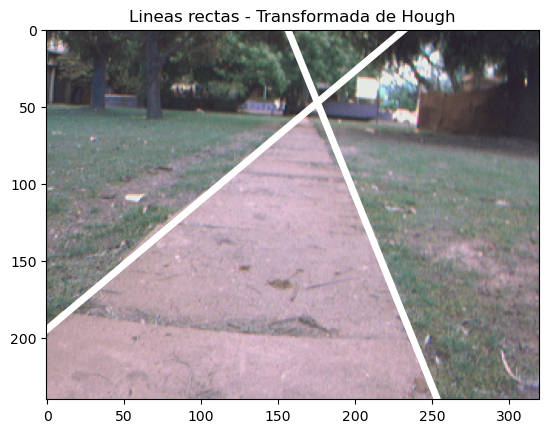

In [295]:
muestra_lineas(frame, resultados)

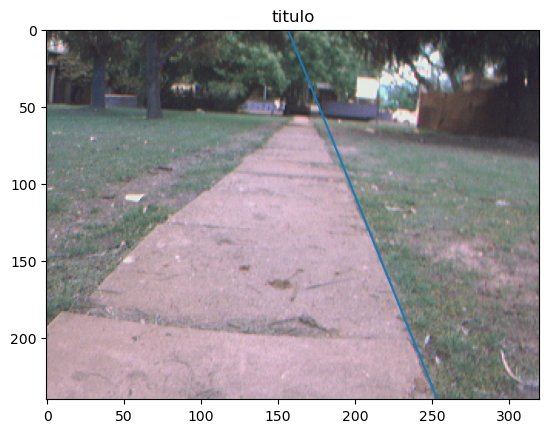

In [276]:
muestra_linea(frame, angulos[resultados[1][1]], (resultados[1][0] - maximo))

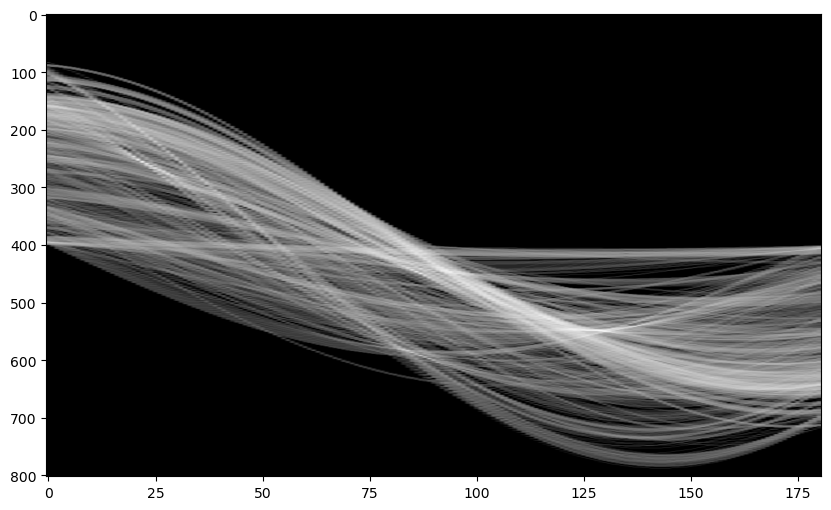

In [158]:
plt.figure(figsize=(10, 6))
plt.imshow(pasarALog(A), cmap='gray', vmin=0, vmax=255)
plt.gca().set_aspect('auto')